In [44]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import Hodograph, SkewT
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [45]:
#sounding = open ("KBIS_121222_1200.txt","r").readlines()

In [46]:
#data = pd.read_csv("KBIS_121222_1200.txt", delimiter = ",")
#print(data)

year = 2022
month = 12
day = 12
hour = 12
station = "KBIS"

dt = datetime(year=year,month=month,day=day,hour=hour)

#convert datetime object to string to add into the IEM url
t = dt.strftime('%Y%m%d%H%M')

#define the url
url = f"https://mesonet.agron.iastate.edu/json/raob.py?ts={t}&station={station}"

#read the json sounding data using pandas
json = pd.read_json(url)

#convert the json sounding to a pandas dataframe
df = pd.json_normalize(json.profiles[0],'profile',['station','valid'])

#convert the "valid" variable to a datetime object
df['valid'] = pd.to_datetime(df['valid'])


In [47]:
df_temp = df.dropna(subset=["tmpc", "dwpc"])
df_temp = df_temp[["pres","hght","tmpc","dwpc"]]

df_wind= df.dropna(subset = ["sknt","drct"])
df_wind = df_wind[["pres","hght","sknt","drct"]]


In [48]:
pressure = np.array(df_temp['pres'].values)* units('millibar')
height = np.array(df_temp['hght'].values) * units('meters')
temperature = np.array(df_temp['tmpc'].values) * units('degC')
dewpoint = np.array(df_temp['dwpc'].values) * units('degC')

In [49]:
wind_pressure = np.array(df_wind['pres'].values) * units('millibar')
wind_height = np.array(df_wind['hght'].values) * units('meters')
wind_speed = np.array(df_wind['sknt'].values) * units('knots')
wind_direction = np.array(df_wind['drct'].values) * units('degrees')

In [50]:
u,v = mpcalc.wind_components(wind_speed,wind_direction)

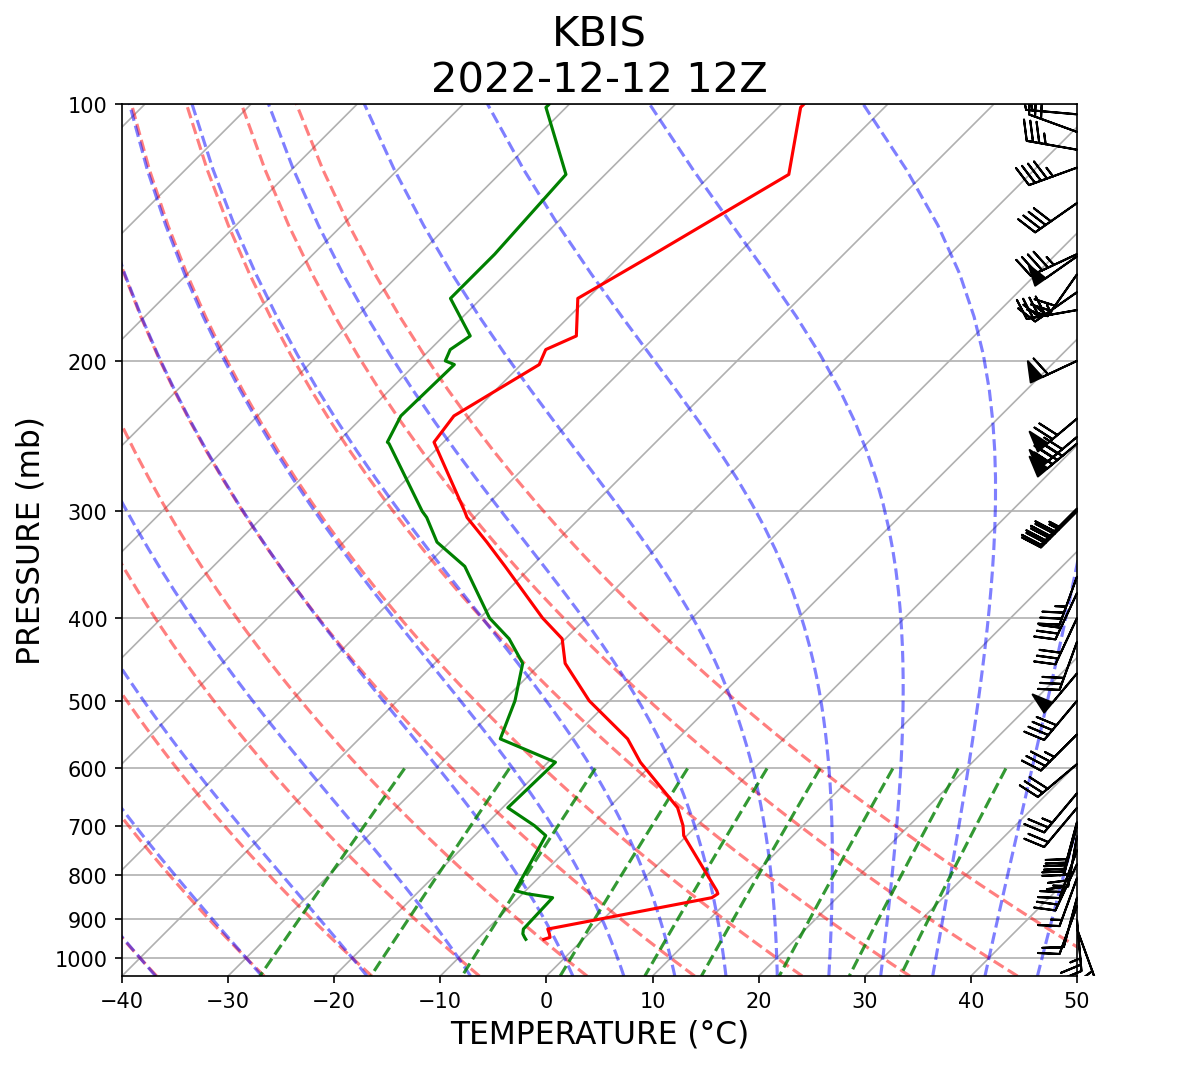

In [53]:
#create skew-t figure
fig = plt.figure(figsize=(8, 9), dpi=150,facecolor='w')
skew = SkewT(fig, rotation=45)

#plot temperature in red and dewpoint in green
plt.plot(temperature, pressure, color = 'red')
plt.plot(dewpoint, pressure, color = 'green')

#create axes labels
plt.xlabel('TEMPERATURE (\N{degree sign}C)',fontsize=15)
plt.ylabel('PRESSURE (mb)',fontsize=15)

#add in typical lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#plot winds 
#only plot every other wind barb so it's not too busy
#(y_clip_radius keeps barbs from plotting outside of skew-t)
skew.plot_barbs(wind_pressure[2:],u[2:],v[2:],y_clip_radius=0)

#add title for date and location
plt.title(f'{station}\n%04i-%02i-%02i %02iZ'%(year,month,day,hour), fontsize=20)

#save figure
fig.tight_layout()
plt.savefig(f'{station}_%04i%02i%02i_%02i.png'%(year,month,day,hour))